In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler

In [2]:
torch.manual_seed(1)

In [3]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=False)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [4]:
# Data loader func
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader

In [5]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        # self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # flatten as one dimension
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))

        x = self.fc3(x)
        return x

In [6]:
#train function
def trainFunc(model,num_epochs,train_batch_size,status_interval):
    model.train()
    print('strated')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    epoch = 0
    modelParamWgt={}
    for epoch in range (num_epochs):
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0

        for i, (images, labels) in enumerate(train_load):  
            #if (i+1)% 60 == 0 : print(i+1)
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            
            # Forward pass
            prediction = model(images)

            images.requires_grad = True

            loss = loss_func(prediction, labels)
            lossSum += loss

            # Backward and optimize
            
            loss.backward()

            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)

            #print(epoch,i)
            
            #Weight Collection
            if epoch % 3 == 0:
                for name, parameter in model.named_parameters():
                    #print(name)
                    if'weight' in name:
                        modelParamWgt[epoch] = torch.nn.utils.parameters_to_vector(parameter).detach().numpy()
                        #print(modelParamWgt)

            #Print Status
            if (i+1) % status_interval == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r',flush = True)
               
                        
    trainAvgLoss = lossSum/train_batch_size
    print("Train Avg loss:",trainAvgLoss)
                        
    return train_epoch,train_losses,train_acc,trainAvgLoss, modelParamWgt

In [7]:
def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss}',end= '\r',flush = True)
    return netTest_acc1, netTest_loss

In [19]:
def pcaOps(paramDF,itr):
    pcaOperation =  PCA(n_components=2)

    scale = StandardScaler()

    sData = scale.fit_transform(paramDF)

    pcaVal = pcaOperation.fit_transform(sData)

    itrData = np.full((pcaVal.shape[0],1),itr)

    #pcaDf = pd.DataFrame(data = pcaVal, columns = ['x','y'])

    pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    return pcaDf


In [43]:
#Main Implementation

modelParamArr = []
pcaDf = pd.DataFrame(columns=['x','y','Itr No.'])


for itr in range(8):
    print('Iteration No:', itr)
    j = copy.deepcopy(itr) 
    j = Model()
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(j.parameters(), lr=0.0015, weight_decay = 1e-4)

    max_epochs = 15
    train_batch_size = int(6000)
    test_batch_size = int(100)
    status_interval = 10

    train_epoch,train_losses,train_acc,trainAvgLoss, modelParamWgt = trainFunc(j,max_epochs,train_batch_size,status_interval)

    testAcc, testLoss = testFunction(j,loss_func,test_batch_size)

    #modelParamArr.append(modelParamWgt.values())

    paramDF = pd.DataFrame.from_dict(data=modelParamWgt,orient='index')

    
    #PCA Dim Reduction.
    pcaOperation =  PCA(n_components=2)

    scale = StandardScaler()

    sData = scale.fit_transform(paramDF)

    pcaVal = pcaOperation.fit_transform(sData)

    itrData = np.full((pcaVal.shape[0],1),itr)

    #pcaDf = pd.DataFrame(data = pcaVal, columns = ['x','y'])

    tempDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    pcaDf = pcaDf.append(tempDf, ignore_index=True)

    #pcaDf = pd.DataFrame(np.append(pcaVal,itrData,axis=1),columns=['x','y','Itr No.'])

    #resultDf = pcaOps(paramDF,itr)



Iteration No: 0
strated
Train Avg loss: tensor(0.0002, grad_fn=<DivBackward0>)
Iteration No: 1 network on the test images: 96.6% & Test Loss: 0.11637420050799846
strated
Train Avg loss: tensor(0.0002, grad_fn=<DivBackward0>)
Iteration No: 2 network on the test images: 97.15% & Test Loss: 0.09444695001351647
strated
Train Avg loss: tensor(0.0002, grad_fn=<DivBackward0>)
Iteration No: 3 network on the test images: 96.78% & Test Loss: 0.10001725410111248
strated
Train Avg loss: tensor(0.0002, grad_fn=<DivBackward0>)
Iteration No: 4 network on the test images: 96.75% & Test Loss: 0.10693266620626674
strated
Train Avg loss: tensor(0.0002, grad_fn=<DivBackward0>)
Iteration No: 5 network on the test images: 96.81% & Test Loss: 0.09956782429013401
strated
Train Avg loss: tensor(0.0002, grad_fn=<DivBackward0>)
Iteration No: 6 network on the test images: 96.8% & Test Loss: 0.10986123773036524
strated
Train Avg loss: tensor(0.0002, grad_fn=<DivBackward0>)
Iteration No: 7 network on the test image

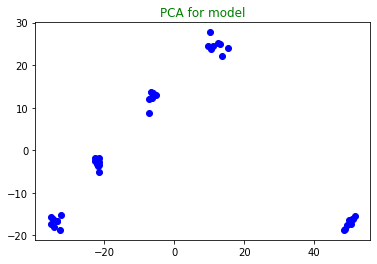

In [44]:
#Visualize the Optimization Process

plt.scatter(pcaDf['x'],pcaDf['y'],color="Blue")
plt.title("PCA for model",color="g")

plt.show()

In [45]:
pcaDf

,x,y,Itr No.
0,50.843964,-16.185280,0.0
1,10.213867,27.728584,0.0
2,-7.169346,8.804453,0.0
3,-21.520700,-5.142484,0.0
4,-32.367771,-15.205253,0.0
5,51.557999,-15.506945,1.0
6,10.430465,23.844307,1.0
7,-7.058244,12.046673,1.0
8,-21.575172,-3.742217,1.0
9,-33.355087,-16.641815,1.0


In [46]:
paramDF

,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
3,-0.118109,0.005786,-0.084581,0.074787,0.016718,-0.003488,-0.008653,0.030069,0.103357,-0.113688,...,0.065332,0.003742,-0.063955,0.058539,-0.088561,0.128292,-0.036612,-0.025034,0.033301,0.084203
6,-0.124281,0.013263,-0.088082,0.066617,-0.000939,-0.003010,-0.015071,0.013216,0.106066,-0.114422,...,0.079601,-0.003994,-0.064810,0.059908,-0.114571,0.141079,-0.016900,-0.043026,0.031612,0.093656
9,-0.121230,0.021098,-0.086581,0.053912,-0.001117,-0.002943,-0.007953,0.027960,0.104072,-0.115558,...,0.084418,0.005479,-0.059205,0.063091,-0.115257,0.141756,-0.012161,-0.043945,0.030065,0.093179
12,-0.118788,0.024208,-0.084046,0.047746,-0.000536,-0.002894,-0.002317,0.037025,0.105262,-0.116889,...,0.088099,0.011706,-0.053806,0.066676,-0.116808,0.142506,-0.010726,-0.043780,0.028342,0.091495
15,-0.117277,0.024864,-0.080404,0.042379,-0.018265,-0.002840,0.001747,0.041063,0.105620,-0.118768,...,0.092239,0.017100,-0.049898,0.071013,-0.118144,0.144963,-0.011053,-0.042347,0.026491,0.090288
